<html>
<head>
  <font size="+5">Predicting Titanic Passenger survivors</font>
</head>
</html>

# Problem Definition

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

> The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

# Data



The data, taken from here (https://www.kaggle.com/c/titanic/data), are divided in this way:

* For the training set, it's provided the outcome (also known as the “ground truth”) for each passenger. In training, there are 891 record with 12 attributes, later explained.

* The test set should be used to see how well your model performs on unseen data. For the test set, it is not provided the ground truth for each passenger. 



# Evaluation 

> Good results, without knowing the Test solution, is around 78/80%

# Features 

## *TITANIC DICTIONARY:*

1. PassengerId  (an integer to identify the passenger)
2. Survived (Survival, i.e. what we should predict):	
 * 0 = No, 
 * 1 = Yes 
3. Pclass (Ticket class):      
 * 1 = 1st, 
 * 2 = 2nd, 
 * 3 = 3rd 
4. Name:        String of the name 
5. Sex:         Person Gender 
6. Age:         Person Age
7. SibSp:       integer, # of siblings / spouses aboard the Titanic
8. Parch:       # of parents / children aboard the Titanic
9. Ticket:      Ticket number	
10. Fare:       Passenger Fare 
11. Cabin:      Cabin number
12. Embarked (Port of Embarkation):   	
 * C = Cherbourg, 
 * Q = Queenstown, 
 * S = Southampton


In [1]:
# Preparing tools: Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Load data and First Impressions

In [2]:
train = pd.read_csv("../data/train.csv")
train.shape

(891, 12)

In [3]:
train.columns # name of the columns, i.e. the dictionary

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
# How is the target distributed?
train.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

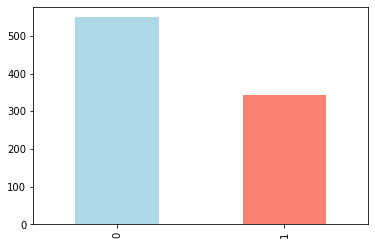

In [5]:
# Let's plot it
train.Survived.value_counts().plot(kind="bar", color=["lightblue", "salmon"]);

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## EDA: Exploratory Data Analysis 

Idea: Gender, Class, Age are probably highly influent, so let's try them.

Let's see the correlation between: 
 * Sex and Survival,
 * Class and Survival, 
 * Age and Survival.

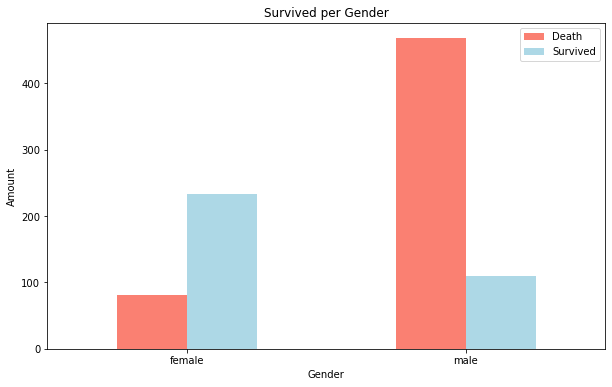

In [7]:
pd.crosstab(train.Sex, train.Survived).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"]);
plt.title("Survived per Gender")
plt.xlabel("Gender")
plt.ylabel("Amount")
plt.xticks(rotation=0)
plt.legend(["Death", "Survived"]);

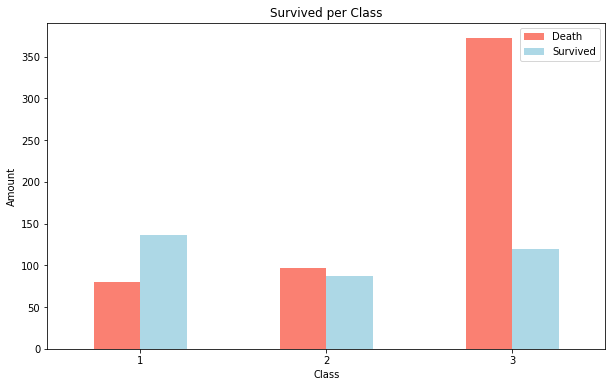

In [8]:
pd.crosstab(train.Pclass, train.Survived).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"]);
plt.title("Survived per Class")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.xticks(rotation=0)
plt.legend(["Death", "Survived"]);

The age is different to treat, since is more continuous than discrete. I'll try to discretize it. Before I need to see how it's distributed in the dataset.

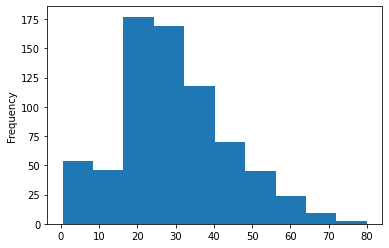

In [9]:
train.Age.plot.hist();

In [10]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
train['age_binned'] = pd.cut(train['Age'], bins)

In [11]:
train.age_binned.value_counts().sort_index()

(0, 10]      64
(10, 20]    115
(20, 30]    230
(30, 40]    155
(40, 50]     86
(50, 60]     42
(60, 70]     17
(70, 80]      5
Name: age_binned, dtype: int64

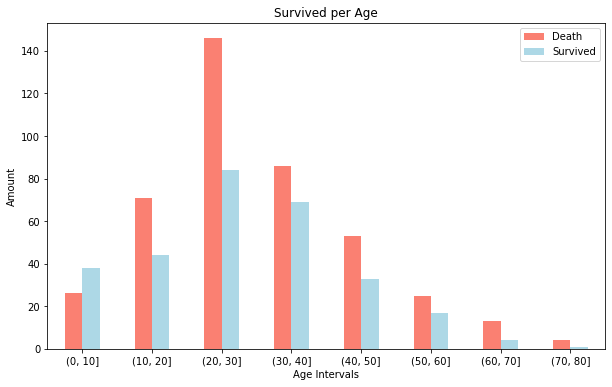

In [12]:
pd.crosstab(train.age_binned, train.Survived).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"]);
plt.title("Survived per Age")
plt.xlabel("Age Intervals")
plt.ylabel("Amount")
plt.xticks(rotation=0)
plt.legend(["Death", "Survived"]);

In [13]:
train = train.drop('age_binned', axis=1)

**Let's see the other attributes:**

* `SibSp`, `Parch` --> These two attributes mean basically: Were they trying to save entire families or anyone they could? Let's see!


In [14]:
train.SibSp.value_counts().sort_index(), train.Parch.value_counts().sort_index()

(0    608
 1    209
 2     28
 3     16
 4     18
 5      5
 8      7
 Name: SibSp, dtype: int64,
 0    678
 1    118
 2     80
 3      5
 4      4
 5      5
 6      1
 Name: Parch, dtype: int64)

In [15]:
pd.crosstab(train.Survived, train.SibSp) # 0 death, 1 save

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


In [16]:
pd.crosstab(train.Survived, train.Parch) # 0 death, 1 save

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


It isn't possible to prove this hypotesis: too many people without parents/children are making noise in the data, which is impossible to erase. 

Let's see the `Ticket`

In [17]:
train.Ticket.value_counts()

1601        7
CA. 2343    7
347082      7
CA 2144     6
3101295     6
           ..
244310      1
PP 4348     1
330979      1
330958      1
36967       1
Name: Ticket, Length: 681, dtype: int64

In [18]:
# How many ticket do I have?
len(train.Ticket.unique())

681

Some people shared the same ticket, so maybe they were saved together. It's a variable to take into account. 

We focus now on `Fare`

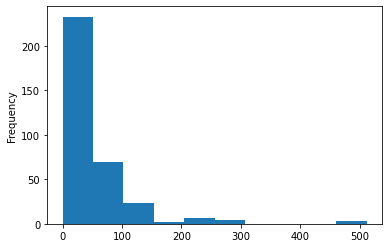

In [19]:
train.Fare[train.Survived == 1].plot.hist();

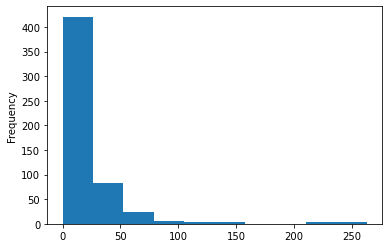

In [20]:
train.Fare[train.Survived == 0].plot.hist();

In [21]:
len(train.Cabin.unique())

148

We can't exclude it, however at the end we'll see how important it is for the predictions.

Regarding `Cabin` we have only 200 record over 891 which are different from `NaN`, where only 148 are different, i.e. there are very small group that can be formed, so not important correlation. For this reason, I suppose the best idea is to remove it for the training. At the end of the day, I changed my mind and I used more data possible. 

The last attribute is `Embarked`, where it is not possible to see any important correlation. 

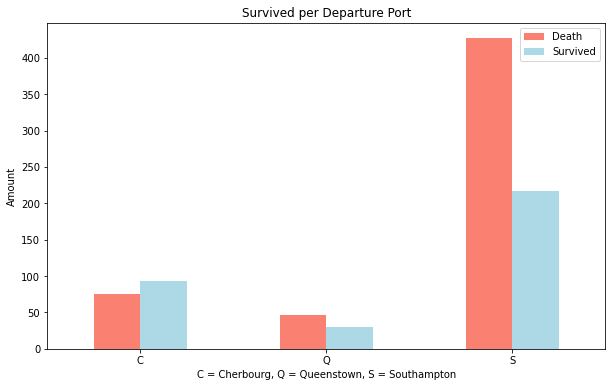

In [22]:
pd.crosstab(train.Embarked, train.Survived).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.legend(["Death", "Survived"])
plt.title("Survived per Departure Port")
plt.xlabel("C = Cherbourg, Q = Queenstown, S = Southampton")
plt.ylabel("Amount")
plt.xticks(rotation=0);

## Data Preprocessing

I need to create a function that prepares my dataset in a way that is useful: I have to eliminate `NaN` and make everything numerical. 

In [23]:
X = train.drop("Survived", axis=1)
y = train.Survived

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [25]:
def cleaning_dataset(X):
    """
    This function prepare the dataset without considering the target. 
    """
    # If the dataset is Test Data
    print("I prepare the dataset")
    # elimino Cabin e Name
    X = X.drop("Name", axis=1)
    X = X.drop("Ticket", axis=1)
    X = X.drop("Cabin", axis=1)
    # Fill NaN
    # X.Cabin.fillna("Missing", inplace=True)
    X.Fare.fillna(0, inplace=True)
    X["Age"].fillna(X.Age.median(), inplace=True)
    X.Embarked.fillna("S", inplace=True)
    # everything is numerical
    categorical_features = ["Sex", "Embarked"] # "Ticket", "Cabin", 
    one_hot = OneHotEncoder()
    transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")
    transformed_X = transformer.fit_transform(X)
    print("Done")
    return transformed_X

In [26]:
X = train.drop("Survived", axis=1)
X = cleaning_dataset(X)

I prepare the dataset
Done


# Model 

In [27]:
# Model from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [29]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
# To avoid rewrite each time the code, we'll put it into a dictionary
models = {" Logistic Regression":LogisticRegression(max_iter=10000), 
          "KNN":KNeighborsClassifier(),
          "Random Forest":RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dictionary of different scikit-learn models, 
    etc...
    it returns a dictionary with models and accuracy 
    """
    # Set random seed
    np.random.seed(42)
    # Make dictionary to keep model score
    model_scores = {}
    # Loop through models
    for name, model in models.items(): 
        # name = key, models = value
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append the score
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [31]:
model_scores = fit_and_score(models=models, 
                             X_train=X_train, 
                             X_test=X_test, 
                             y_train=y_train, 
                             y_test=y_test)

model_scores

{' Logistic Regression': 0.7988826815642458,
 'KNN': 0.659217877094972,
 'Random Forest': 0.8324022346368715}

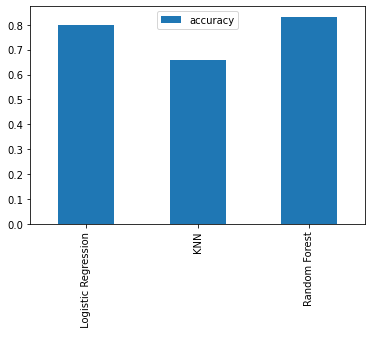

In [32]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

## Maybe KNN doesn't have the perfect tune

In [33]:
# Let's tune KNN 

train_scores = []
test_scores = []

# create a list of n_neighbors
neighbors = range(1, 21)
# Setup KNN instance
knn = KNeighborsClassifier()
for i in neighbors:
    knn.set_params(n_neighbors=i)
    # fit the algorithm
    knn.fit(X_train, y_train)
    # score train and test
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

Best n_neighbors is 19
Maximum score obtained on the test data is 68.72% 


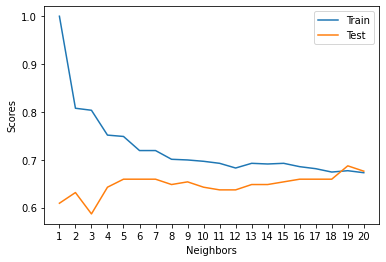

In [34]:
plt.plot(neighbors, train_scores, label="Train Scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Neighbors")
plt.ylabel("Scores")
plt.legend(["Train", "Test"]);

print("Best n_neighbors is " + str(np.argmax(test_scores) + 1)) # perché partiamo da 1
print(f"Maximum score obtained on the test data is {max(test_scores)*100:.2f}% ")

KNN is not the best choiche for this dataset. Let's study better the others.

## RandomizedSearchCV 

### Logistic Regression

In [35]:
# Create an hyperparameter grid Logistic Regression
log_reg_grid = {"C":np.logspace(-4, 4, 20), 
                "penalty" : ['l1', 'l2'],
                "solver": ['saga', 'liblinear']}

# Create an hyperparameter grid for Random Forest
rf_grid = {"n_estimators":np.arange(10, 1000, 50), 
           "max_depth":[None, 3, 5, 10], 
           "min_samples_split":np.arange(2, 20, 2), 
           "min_samples_leaf":np.arange(1, 20, 2)}

In [36]:
# Let's use it
np.random.seed(42)
# Setup random parameters 
rs_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=10000), 
                                param_distributions=log_reg_grid, 
                                cv=5, 
                                n_iter=20, 
                                verbose=True)
# fit random hyperparameters
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.4s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
                   n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['saga', 'liblinear']},
                   verbose=True)

In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.23357214690901212}

In [38]:
rs_log_reg.score(X_test, y_test)

0.7821229050279329

### Random Forest

In [39]:
# Let's use it
np.random.seed(42)
# Setup random parameters 
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid, 
                           cv=5, 
                           n_iter=20, 
                           verbose=True)
# fit random hyperparameters
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [40]:
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [41]:
rs_rf.score(X_test, y_test)

0.8100558659217877

`LogisticRegression()` has not defeated `RandomForestClassifier()`. With this in mind, I'll try to find the best parameter for it using `GridSearchCV`.

## GridSearchCV

In [42]:
# Create an hyperparameter grid Logistic Regression
# log_reg_grid = {"C":np.logspace(-4, 4, 30), "solver": ['liblinear', 'saga']}

# Create an hyperparameter grid for Random Forest
rf_grid = {"n_estimators":np.arange(900, 1000, 8), 
           "max_depth":[None, 5, 10], 
           "min_samples_split":np.arange(16, 22, 2), 
           "min_samples_leaf":np.arange(1, 4, 2)}


# setup GridSearch for logistic regression
gs_rf_reg = GridSearchCV(RandomForestClassifier(), # LogisticRegression(max_iter=10000), 
                          param_grid=rf_grid, #log_reg_grid, 
                          cv=5, 
                          verbose=True)

gs_rf_reg.fit(X_train, y_train)

Fitting 5 folds for each of 234 candidates, totalling 1170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed: 44.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': array([1, 3]),
                         'min_samples_split': array([16, 18, 20]),
                         'n_estimators': array([900, 908, 916, 924, 932, 940, 948, 956, 964, 972, 980, 988, 996])},
             verbose=True)

In [43]:
# Check the best hyperparameters
gs_rf_reg.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 916}

In [44]:
gs_rf_reg.score(X_test, y_test)

0.8156424581005587

# Evaluating our tuned machine learning classifier, beyond accuracy 

* ROC Curve and AUC score 
* Confusion Matrix
* Classification Report
* Precision
* Recall
* F1-score

... using Cross-validation whenever is possible

To make comparison and evaluate our trained model, first we have to make prediction

In [53]:
# Make Prediction
y_preds = gs_rf_reg.predict(X_test)

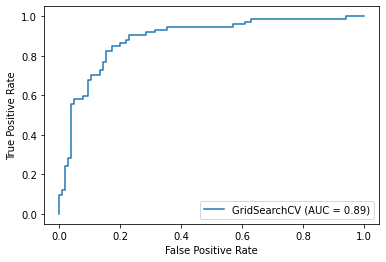

In [46]:
# Plot ROC Curve and calculate AUC metrics
plot_roc_curve(gs_rf_reg, X_test, y_test);

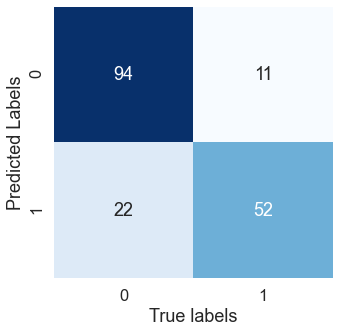

In [54]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's Heatmap()
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), 
                     annot=True,
                     cmap='Blues', 
                     fmt='g',
                     cbar=False)
    plt.xlabel("True labels")
    plt.ylabel("Predicted Labels")
    
plot_conf_mat(y_test, y_preds)

In [55]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



okay, but we don't have cross validation!

## Calculate evaluation metrics using cross-validation

We're going to calculate precision, recall and f1-score with cross validation, by `cross_val_score()`

In [56]:
# check best hyperparams
gs_rf_reg.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 916}

In [57]:
# create a new classifier 
clf = RandomForestClassifier(max_depth=None, 
                             min_samples_leaf=1,
                             min_samples_split=6,
                             n_estimators=298)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=6, n_estimators=298)

In [58]:
# Cross-validate accuracy 
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.809277509258678

In [59]:
# Cross-validate precision
cv_pre = cross_val_score(clf, X, y, cv=5, scoring="precision")
cv_pre = np.mean(cv_pre)
cv_pre

0.8227132038376416

In [60]:
# Cross-validate recall
cv_rec = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_rec = np.mean(cv_rec)
cv_rec

0.6407502131287297

In [61]:
# Cross-validate f1-score
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.7034898328609164

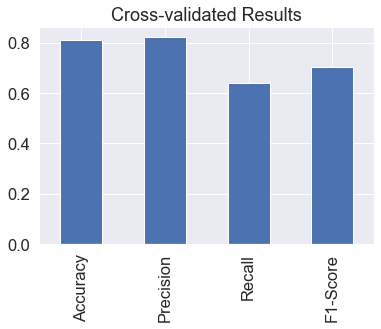

In [62]:
# Visualize our metrics
cv_metrics = pd.DataFrame({"Accuracy":cv_acc, 
                           "Precision":cv_pre, 
                           "Recall":cv_rec, 
                           "F1-Score":cv_f1}, index=[0])
cv_metrics.T.plot.bar(title="Cross-validated Results", legend=False);

# Save the Model



In [84]:
import pickle 

In [85]:
# Save an extisting model to file 
pickle.dump(clf, open("../model/random_forest.pkl", "wb"))

In [89]:
# load an extisting model
clf = pickle.load(open("../model/random_forest.pkl", "rb"))

In [92]:
clf.score(X_test, y_test)

0.8385650224215246

# Submission Kaggle

## Train Again

In [63]:
train_2 = train.drop("Survived", axis=1)
train_2 = cleaning_dataset(train_2)

I prepare the dataset
Done


In [64]:
clf = RandomForestClassifier(max_depth=None, 
                             min_samples_leaf=1,
                             min_samples_split=6,
                             n_estimators=298)
clf.fit(train_2, y)

RandomForestClassifier(min_samples_split=6, n_estimators=298)

In [95]:
test = pd.read_csv("../data/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [103]:
test_2 = cleaning_dataset(test)
test_2.shape, train_2.shape

I prepare the dataset
Done


((418, 11), (891, 11))

## Submission

In [100]:
test_preds = clf.predict(test_2)

In [108]:
ds = pd.DataFrame()
ds["PassengerId"] = test.PassengerId
ds["Survived"] = test_preds

In [112]:
ds.shape

(418, 2)

In [114]:
ds.to_csv("../submission/titanic_results.csv", index=False)